# Forward projection 


In [1]:
import cupy as cp
import kernelkit as kk
import matplotlib.pyplot as plt
import numpy as np
from tomopy.misc.phantom import shepp3d  # requires installing tomopy

## 3D Shepp-Logan phantom 

We install the `tomopy` package for theShepp-Logan phantom, and display the three orthoggonal "projections" by summing the 3D array along each of its axis. The axes convention of *Tomopy* is $(z, y, x)$.

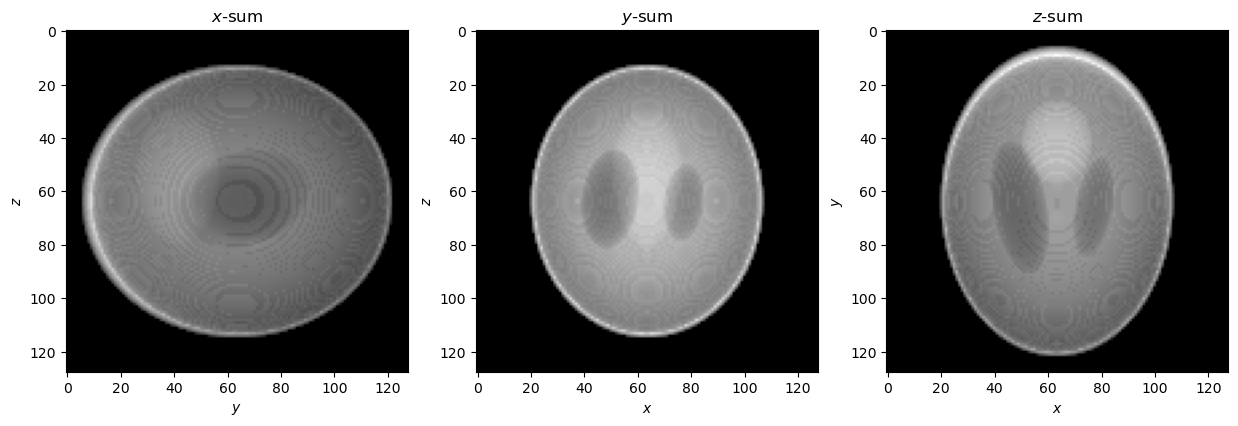

In [2]:
# phantom
N_x = 128
vol_cpu = np.ascontiguousarray(shepp3d(size=N_x))


axis_integrals = [np.sum(vol_cpu, axis=i) for i in range(3)]

kwargs = {'origin': 'upper', 'interpolation': None, 'cmap': 'gray',
          'aspect': 'equal', 'vmin': 0.0, 'vmax': axis_integrals[0].max()}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('$x$-sum')
axs[0].imshow(axis_integrals[2], **kwargs)
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$z$')
axs[1].set_title('$y$-sum')
axs[1].imshow(axis_integrals[1], **kwargs)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$z$')
axs[2].set_title('$z$-sum')
axs[2].imshow(axis_integrals[0], **kwargs)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$y$')
plt.show()

## Forward projector

We will replicate the projections with the KernelKit forward projector. We first set up three projection geometries, `x_proj`, `y_proj`, and `z_proj`, choosing the detector axis $(u, v)$ in the positive $x$, $y$, $z$ directions.


In [19]:
det = kk.Detector(rows=N_x, cols=N_x, pixel_width=2./N_x, pixel_height=2./N_x)

dist = 1e8  # approximates parallel beam
x_proj = kk.ProjectionGeometry(
    source_position=[-dist, 0, 0],
    detector_position=[dist, 0, 0],  # magnification factor: SDD/SOD = 2
    u=[0, 1, 0],  # To match the numpy averages through an axis,
    v=[0, 0, 1],  # we choose the (+1, +1)-axes for u, v in all projections.
    detector=det)
y_proj = kk.ProjectionGeometry(
    source_position=[0, -dist, 0],
    detector_position=[0, dist, 0],
    u=[1, 0, 0],
    v=[0, 0, 1],
    detector=det)
z_proj = kk.ProjectionGeometry(
    source_position=[0, 0, -dist],
    detector_position=[0, 0, dist],
    u=[1, 0, 0],
    v=[0, 1, 0],
    detector=det)

vol_geom = kk.VolumeGeometry(
    shape=[N_x] * 3,
    extent_min=[-.5] * 3,
    extent_max=[.5] * 3,
    voxel_size=[1. / N_x] * 3)

We let the Shepp-Logan array be the data for a $(1., 1., 1.)$-sized volume, in the middle of the space, and inform KernelKit via the `volume_axis=(2, 1, 0)` that the volume is stored as $(z, y, x)$. 

In [20]:
fp = kk.ForwardProjector(volume_axes=(2, 1, 0))

# Setting attributes is backed by projector intelligence
fp.volume_geometry     = vol_geom
fp.projection_geometry = [x_proj, y_proj, z_proj]
fp.volume              = cp.asarray(vol_cpu, dtype=cp.float32)
fp.projections         = cp.empty((3, det.rows, det.cols), dtype=cp.float32)

# Calling the object executes the projector
fp()

Compiling kernel RayDrivenConeFP with arguments {'slices_per_block': 64, 'rows_per_block': 64, 'cols_per_block': 64, 'nr_projs_global': 1024, 'volume_axes': (2, 1, 0), 'projection_axes': (0, 1, 2)}...


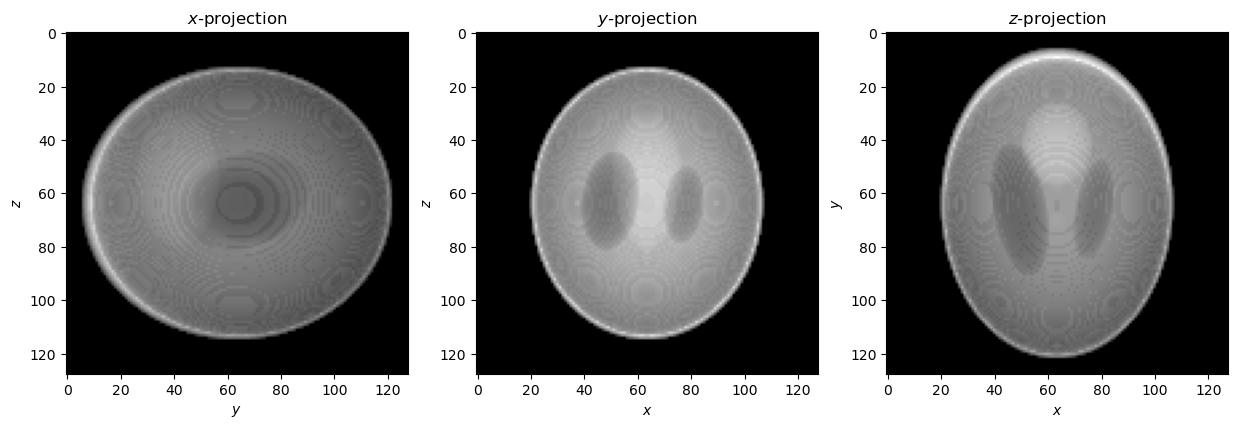

In [25]:
# Attribute getters allow you to retrieve objects from the projector
y = fp.projections

kwargs = {'origin': 'upper', 'interpolation': None, 'cmap': 'gray',
          'aspect': 'equal', 'vmin': 0.0, 'vmax': y.max()}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("$x$-projection")
axs[0].imshow(cp.asnumpy(y[0]), **kwargs)
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$z$')
axs[1].set_title("$y$-projection")
axs[1].imshow(cp.asnumpy(y[1]), **kwargs)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$z$')
axs[2].set_title("$z$-projection")
axs[2].imshow(cp.asnumpy(y[2]), **kwargs)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$y$')
plt.show()